In [1]:
import sys
sys.path.append('../scripts') 

import numpy as np
import pandas as pd
from scipy.fft import fft, ifft, fftfreq

from scipy.integrate import simpson
from scipy.interpolate import UnivariateSpline

import qutip
from qutip_tools import *

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys  
from ast import literal_eval

In [2]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../plots/perturbative/"
data_route = "../data/sims/L=21/"


# Functions

In [3]:
def create_hamiltonians(L, T, Bond):
    # creates the decoupled and interacting hamiltonians 
    
    # L_qpc = qpc lattice sites
    # T = qubit hopping
    # BOnd = index for bond locatin
    H_matrix = np.zeros((2*L,2*L))
    # fill in the dd hopping 
    d_indices= kth_diag_indices(H_matrix,1)
    H_matrix[d_indices] = -T
    
    # fill in the QPC hopping
    d_indices= kth_diag_indices(H_matrix,2)
    H_matrix[d_indices] = -J[0]
    
    # when qpc and qubit hop a the same time there is no contribution
    d_indices= kth_diag_indices(H_matrix,1)
    odd_inds = (d_indices[0][1::2], d_indices[1][1::2])
    H_matrix[odd_inds] = 0
    
    # save the free hamiltonian for later use
    Hdeco = H_matrix.copy()
    
    # Fill in the interaction at the bond
    H_matrix[2*Bond,2*(Bond+1)] = H_matrix[2*Bond,2*(Bond+1)]+ Omega
    
    # Now the elemets below the diagonal
    for i in range(0,2*L):
        for j in range(i + 1, 2*L):
            H_matrix[j, i] = H_matrix[i, j]
            Hdeco[j, i] = Hdeco[i, j]
            
    return H_matrix, Hdeco


In [4]:


def separate_band(eigen_array, energy_array):
    # since linalg spits out eigenvalues is some weird order se
    # organize them in the proper band corresponding to the qubit states
    band_list = []
    index_list = []
    for target_ in energy_array:
        closest, index_c = find_nearest(eigen_array, target_)
        band_list.append(closest)
        index_list.append(index_c)
    
    return np.asarray(band_list), index_list
    

def get_projection_colors(state_list, Proj):
    # get the colors for the band in staet list
    # acording to the matrix element of the projection Proj
    colors_ = []
    # calculate the colors
    for i in range(0,np.shape(state_list)[1]):
        # for plus states
        ev = state_list[:,i]
        ev_proj = np.matmul(Proj,ev)
        colors_.append(np.dot(np.conj(ev), ev_proj))
        
    return np.asarray(colors_)


In [5]:
def separate_by_proximity(numeric_energy, numeric_states):
    # sorts numeric energy in accordance to the proximity to the two decoupled bands em0 ep0
    sort_idx = np.argsort(numeric_energy)
    sorted_energies = numeric_energy[sort_idx]
    sorted_states = numeric_states[:,sort_idx]

    marker_list = []

    ep_copy = ep0
    em_copy = em0
    
    for i in range(0, len(sorted_energies)):
        # find the closest state in the plus band
        ep_close, p_idx = find_nearest(ep_copy, sorted_energies[i])
        # find the closest state in the minus band
        em_close, m_idx = find_nearest(em_copy, sorted_energies[i])
        
        # get the difference and sort according to which is the smallest
        dif_plus = abs(sorted_energies[i] - ep_close)
        dif_minus = abs(sorted_energies[i] - em_close)

        # accept in the minus band
        if dif_plus>=dif_minus:
            marker_list.append(0)
            # remove to avoid double counting
            # np.delete(ep_copy, p_idx)
        else:
            marker_list.append(1)
            # np.delete(em_copy, m_idx)
            
    marker_list = np.asarray(marker_list)
    
    idx = np.argwhere(marker_list==1)[:,0]
    plus_energies = sorted_energies[idx]
    plus_states = sorted_states[:,idx]

    idx = np.argwhere(marker_list==0)[:,0]
    minus_energies = sorted_energies[idx]
    minus_states = sorted_states[:,idx]

    return minus_energies, minus_states, plus_energies, plus_states, 

In [6]:

def plot_2_bands(Em_correct, Ep_correct, Energies_m, Energies_p, Colors_m, Colors_p, Figuresize=(13,5)):
    # Em_correct, Ep_correct are the perturbatively corrected energies 
    # Energies_m, Energies_p are the numpy eigenvalues
    fig, ax = plt.subplots(1,2, figsize=Figuresize)
    c_norm = (-0.2,1.2)

    ax[0].plot(k_single_band, Em_correct, c= "red")
    ax[0].plot(k_single_band, Ep_correct, c= "blue")
    # zoomed in 
    ax[1].plot(k_single_band[cut1:cut2], Em_correct[cut1:cut2], c= "red")
    ax[1].plot(k_single_band[cut1:cut2], Ep_correct[cut1:cut2], c= "blue")
    
    # Diagonalized 
    sns.scatterplot(x=k_single_band, y=Energies_p, hue= Colors_p, hue_norm= c_norm, palette="RdBu", 
                    edgecolor="black", legend=None,ax=ax[0])
    
    img = sns.scatterplot(x=k_single_band, y=Energies_m, hue= Colors_m, hue_norm= c_norm, palette="RdBu" , 
                    edgecolor="black", legend=None,ax=ax[0])
    
    # zoomed
    sns.scatterplot(x=k_single_band[cut1:cut2], y=Energies_p[cut1:cut2], hue= Colors_p[cut1:cut2], hue_norm= c_norm, palette="RdBu", 
                    edgecolor="black", legend=None,ax=ax[1])
    
    img = sns.scatterplot(x=k_single_band[cut1:cut2], y=Energies_m[cut1:cut2], hue= Colors_m[cut1:cut2], hue_norm= c_norm, palette="RdBu" , 
                    edgecolor="black", legend=None,ax=ax[1],)

    # Get the scatter object and attach colorbar
    norm = plt.Normalize(c_norm[0], c_norm[1])
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
    sm.set_array([])  # Required for ScalarMappable with no mappable object
    plt.colorbar(sm, ax=ax)
    
    # write x axis in units of pi
    ax[0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                                 r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                                 else '0'))
    
    ax[1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                                 r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                                 else '0'))
    ax[0].set_xlabel(r"$k$")
    ax[0].set_ylabel(r"$E$")
    ax[1].set_xlabel(r"$k$")

    return ax

In [7]:
def plot_2_bands_2sorts(Em_correct, Ep_correct, Energies_m, Energies_p, 
                        Energies_prox_m, Energies_prox_p,Colors_m, Colors_p, 
                        Over_Colors_m, Over_Colors_p, Figuresize=(12,8)):
    # Em_correct, Ep_correct are the perturbatively corrected energies for the proximity and projection sorting
    # Energies_m, Energies_p are the numpy eigenvalues
    fig, ax = plt.subplots(2,2, figsize=Figuresize)

    # -------- For the Projection sorting-------------

    ax[0,0].plot(k_single_band, Em_correct, c= "red")
    ax[0,0].plot(k_single_band, Ep_correct, c= "blue")
    sns.scatterplot(x=k_single_band, y=Energies_p, hue= Colors_p, hue_norm= c_norm, palette="RdBu", 
                    edgecolor="black", legend=None,ax=ax[0,0])
    img = sns.scatterplot(x=k_single_band, y=Energies_m, hue= Colors_m, hue_norm= c_norm, palette="RdBu" , 
                    edgecolor="black", legend=None,ax=ax[0,0])
    
    # zoomed in 
    ax[0,1].plot(k_single_band[cut1:cut2], Em_correct[cut1:cut2], c= "red")
    ax[0,1].plot(k_single_band[cut1:cut2], Ep_correct[cut1:cut2], c= "blue")
    sns.scatterplot(x=k_single_band[cut1:cut2], y=Energies_p[cut1:cut2], hue= Colors_p[cut1:cut2], hue_norm= c_norm, palette="RdBu", 
                    edgecolor="black", legend=None,ax=ax[0,1])
    img = sns.scatterplot(x=k_single_band[cut1:cut2], y=Energies_m[cut1:cut2], hue= Colors_m[cut1:cut2], hue_norm= c_norm, palette="RdBu" , 
                    edgecolor="black", legend=None,ax=ax[0,1],)
    
    # -------- For the overlap sorting-------------
    ax[1,0].plot(k_single_band, Em_correct, c= "red")
    ax[1,0].plot(k_single_band, Ep_correct, c= "blue")
    sns.scatterplot(x=k_single_band, y=Energies_prox_p, hue= Over_Colors_p, hue_norm= c_norm, palette="RdBu", 
                    edgecolor="black", legend=None,ax=ax[1,0])
    img = sns.scatterplot(x=k_single_band, y=Energies_prox_m, hue= Over_Colors_m, hue_norm= c_norm, palette="RdBu" , 
                    edgecolor="black", legend=None,ax=ax[1,0])
    
    # zoomed in 
    ax[1,1].plot(k_single_band[cut1:cut2], Em_correct[cut1:cut2], c= "red")
    ax[1,1].plot(k_single_band[cut1:cut2], Ep_correct[cut1:cut2], c= "blue")
    sns.scatterplot(x=k_single_band[cut1:cut2], y=Energies_prox_p[cut1:cut2], hue= Over_Colors_p[cut1:cut2], hue_norm= c_norm,
                    palette="RdBu", edgecolor="black", legend=None,ax=ax[1,1])
    img = sns.scatterplot(x=k_single_band[cut1:cut2], y=Energies_prox_m[cut1:cut2], hue= Over_Colors_m[cut1:cut2], hue_norm= c_norm, 
                          palette="RdBu" , edgecolor="black", legend=None,ax=ax[1,1],)
    
    # ------ aesthetical things ---------------
    # Get the scatter object and attach colorbar to one of the plots
    norm = plt.Normalize(c_norm[0], c_norm[1])
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
    sm.set_array([])  # Required for ScalarMappable with no mappable object
    plt.colorbar(sm, ax=ax)
    
    # write x axis in units of pi
    ax[0,0].set_title(r"Sorted by Projection")
    ax[0,0].set_xticks([],[])
    ax[0,0].set_ylabel(r"$E$")
    ax[0,1].set_xticks([],[])
    ax[1,0].set_title(r"Sorted by Overlaps")
    ax[1,0].set_xlabel(r"$k$")
    ax[1,0].set_ylabel(r"$E$")
    ax[1,1].set_xlabel(r"$k$")

    ax[1,0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                                 r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                                 else '0'))
    
    ax[1,1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                                 r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                                 else '0'))

    return ax 


# Perturbations to the energy

we compared to the exact diagonalization

## Initialize the System

In [8]:
L_qpc = 60
L = L_qpc + 2
Omega = 0.4
t = 0.05
J_prime = 1
bond_index =  int(L_qpc/2)
J = np.ones(L_qpc) # QPC hopping
J[bond_index] = J_prime  

print(np.pi/(L_qpc+1))

0.05150151891130808


<Axes: >

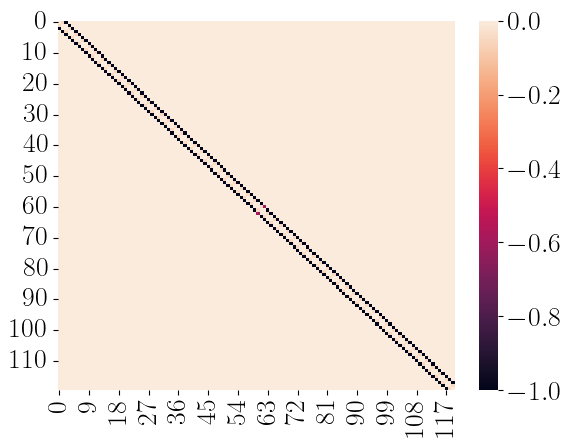

In [9]:
H_matrix, Hdeco = create_hamiltonians(L_qpc, t, bond_index)

sns.heatmap(H_matrix)

In [10]:
# Calculate the energies and eigenvectors
energies, eigen_vecs = np.linalg.eig(H_matrix)
# normalize
eigen_vecs = eigen_vecs/ np.linalg.norm(eigen_vecs, axis=0)

# calculate the decoupled system analytic eigenenergies (zeroth order correction)
k_single_band = np.arange(1,L_qpc+1)*np.pi/(L_qpc+1)
em0 = -2*J[0]*np.cos(k_single_band) - t 
ep0 = -2*J[0]*np.cos(k_single_band) + t 

# find the momenta that we are mostly interested in (far from the edges of the brillouin zone)
_, cut1 = find_nearest(k_single_band, 0.2*np.pi)
_, cut2 = find_nearest(k_single_band, 0.8*np.pi)

np.linspace(0.5*np.pi,1.4*np.pi,5)

array([1.57079633, 2.27765467, 2.98451302, 3.69137137, 4.39822972])

## Sorting into bands
Here we expect two bands, however we have to be carefull because **linalg spits the eigenvectors and states all mixed up instead of in neat bands**. So what we have to do is construct a projection operator and apply it to the eigenstates from numpy. Their values will be either 1 or 0 and with that we will be able to sort them into the proper symmetry bands

### Sorting by Projection

In [11]:
# build the projection opeartor to the qubit-symmetric sector of the hilbert space
Id_qpc = np.eye(L_qpc)
plusket = np.asarray([1/np.sqrt(2),1/np.sqrt(2)])
p_ketbra = np.outer(plusket,plusket)
Psym = np.eye(2*L_qpc) - np.kron(Id_qpc, p_ketbra) # tensor product


In [12]:
mindices, pindices = sort_by_projection(energies,eigen_vecs, Psym)

# minus band
energies_m = energies[mindices]
states_m = eigen_vecs[:,mindices]
# sort by magnitude
energies_m, states_m = mag_sort(energies_m, states_m)

# plus band
energies_p = energies[pindices]
states_p = eigen_vecs[:,pindices]
energies_p, states_p = mag_sort(energies_p, states_p)


# get the colors for each band 
colors_p = get_projection_colors(states_p, Psym)
colors_m = get_projection_colors(states_m, Psym)

### sorting by proximity

Separating with proximity to decoupled energies: **This will not work because sometimes I have eigenvaleus that are very far away annd they wont get assigned at all. Try this one out:**

https://scicomp.stackexchange.com/questions/10708/sorting-eigenvalues-by-the-dominant-contribution 

In [13]:

proximity_m, prox_state_m, proximity_p, prox_state_p = separate_by_proximity(energies, eigen_vecs)

pro_colors_p = get_projection_colors(prox_state_p, Psym)
pro_colors_m = get_projection_colors(prox_state_m, Psym)


### Sorting by Overlap matrix

So the idea is that we grab the eigenvectors of the free system calculated with python and calculate the overlap with those of the coupled system. Coupled vector with the largest overlap will correspond to the $k$ of the free system. Since gor the free system we can perfectly find each $k$ we can therefore also sort the interacting one from that.



In [14]:
# Calculate the energies and eigenvectors
free_energies, free_eigen_vecs = np.linalg.eig(Hdeco)
# normalize
free_eigen_vecs = free_eigen_vecs/ np.linalg.norm(free_eigen_vecs, axis=0)


Text(0.5, 1.0, 'Overlap Matrix')

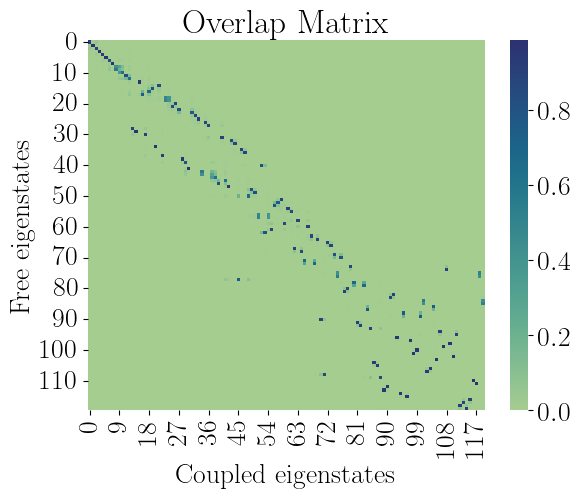

In [16]:
sorted_indices, over_matrix = sort_by_overlap_matrix(energies, free_eigen_vecs,eigen_vecs)

        
sns.heatmap(over_matrix.real,cmap="crest")
plt.xlabel("Coupled eigenstates")
plt.ylabel("Free eigenstates")
plt.title("Overlap Matrix")

In [17]:
# now sort the freee case into bands according to projection
mindices, pindices = sort_by_projection(free_energies,free_eigen_vecs, Psym)

# minus band
free_energies_m = free_energies[mindices]
free_states_m = free_eigen_vecs[:,mindices]
# sort by magnitude
free_energies_m, free_states_m = mag_sort(free_energies_m, free_states_m)

# plus band
free_energies_p = free_energies[pindices]
free_states_p = free_eigen_vecs[:,pindices]
# sort by magnitude
free_energies_p, free_states_p = mag_sort(free_energies_p, free_states_p)


In [18]:
# now sort the coupled eigenvectors and values according to max overlaps so they match with the free case
sorted_e = energies[sorted_indices]
sorted_vecs = eigen_vecs[:,sorted_indices]

# minus band
over_energies_m = sorted_e[mindices]
over_states_m = sorted_vecs[:,mindices]
# sort by magnitude
over_energies_m, over_states_m = mag_sort(over_energies_m, over_states_m)

# plus band
over_energies_p = sorted_e[pindices]
over_states_p = sorted_vecs[:,pindices]
# sort by magnitude
over_energies_p, over_states_p = mag_sort(over_energies_p, over_states_p)

# get the colors for each band 
over_colors_p = get_projection_colors(over_states_p, Psym)
over_colors_m = get_projection_colors(over_states_m, Psym)


### Comparing the methods

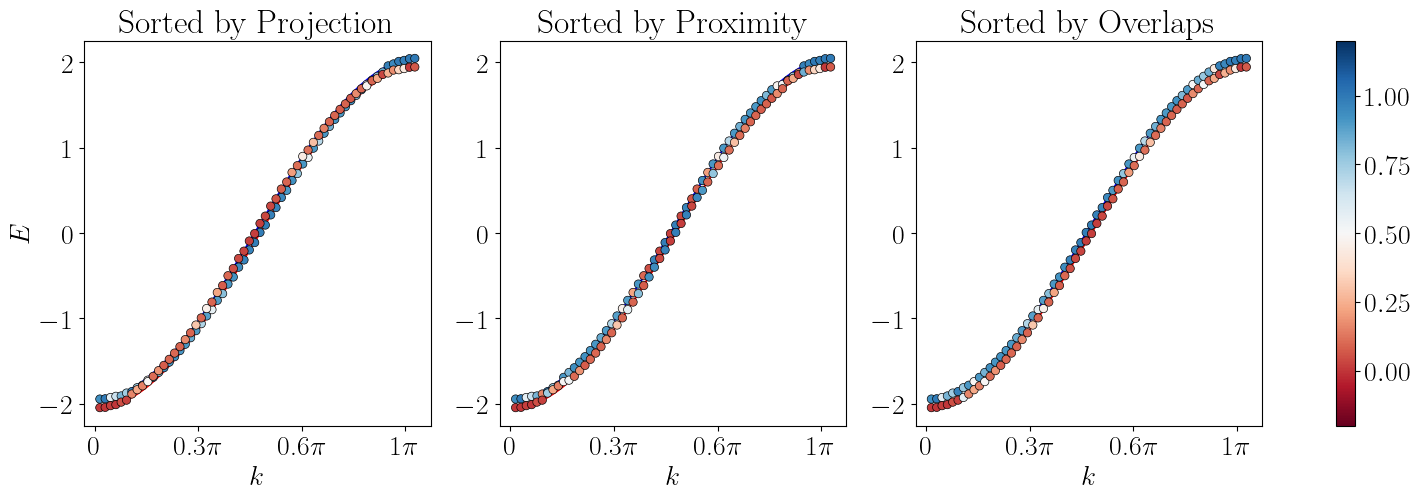

In [19]:
fig, ax = plt.subplots(1,3, figsize=(19,5))

c_norm = (-0.2,1.2)
cmap = "RdBu"
# zeroth order analytic stuff
ax[0].plot(k_single_band, em0, c= "red",zorder=0)
ax[0].plot(k_single_band, ep0, c= "blue",zorder=0)

ax[1].plot(k_single_band, em0, c= "red",zorder=0)
ax[1].plot(k_single_band, ep0, c= "blue",zorder=0)

ax[2].plot(k_single_band, em0, c= "red", zorder=0)
ax[2].plot(k_single_band, ep0, c= "blue",zorder=0)

# projection
sns.scatterplot(x=k_single_band, y=energies_p, hue= colors_p, hue_norm= c_norm, palette=cmap ,
                edgecolor="black",legend=None, ax=ax[0])
sns.scatterplot(x=k_single_band, y=energies_m, hue= colors_m, hue_norm= c_norm, palette=cmap ,
                edgecolor="black", legend=None,ax=ax[0])

# proximity 
sns.scatterplot(x=k_single_band, y=proximity_p, hue= pro_colors_p, hue_norm= c_norm, palette=cmap, 
                edgecolor="black", legend=None,ax=ax[1])

sns.scatterplot(x=k_single_band, y=proximity_m, hue= pro_colors_m, hue_norm= c_norm, palette=cmap, 
                edgecolor="black", legend=None,ax=ax[1])

# overlaps
sns.scatterplot(x=k_single_band, y=over_energies_p, hue= over_colors_p, hue_norm= c_norm, palette=cmap ,
                edgecolor="black",legend=None, ax=ax[2])

img = sns.scatterplot(x=k_single_band, y=over_energies_m, hue= over_colors_m, palette=cmap ,hue_norm= c_norm,
                edgecolor="black", legend=None,ax=ax[2])

ax[0].set_xlabel(r"$k$")
ax[0].set_ylabel(r"$E$")
ax[0].set_title(r"Sorted by Projection")

ax[1].set_xlabel(r"$k$")
ax[1].set_title(r"Sorted by Proximity")

ax[2].set_xlabel(r"$k$")
ax[2].set_title(r"Sorted by Overlaps")


# Get the scatter object and attach colorbar
norm = plt.Normalize(c_norm[0], c_norm[1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable with no mappable object
plt.colorbar(sm, ax=ax)

# write x axis in units of pi
ax[0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

ax[1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

ax[2].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

# plt.savefig(fig_route+"sorting_compare_Lqpc={}_Omega={}_t={}.pdf".format(L_qpc, Omega,t),bbox_inches='tight')


Compare energy gaps wrt the decoiupled case

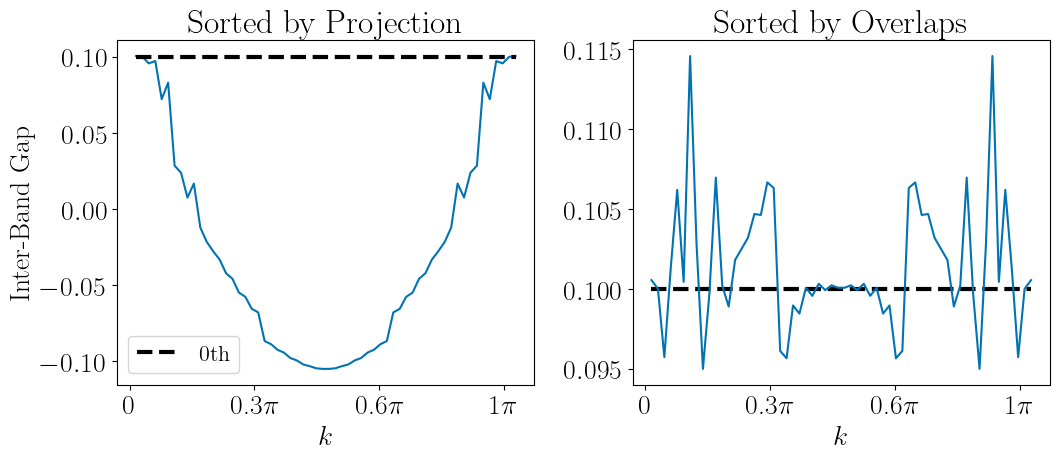

In [20]:
fig, ax = plt.subplots(1,2, figsize=(11,5))


ax[0].plot(k_single_band, energies_p-energies_m)
ax[0].plot(k_single_band, ep0-em0, c="black", linewidth=3, linestyle="dashed", label="0th")

ax[1].plot(k_single_band, ep0-em0, c="black", linewidth=3, linestyle="dashed", label="0th")
ax[1].plot(k_single_band, over_energies_p-over_energies_m)

ax[0].set_xlabel(r"$k$")
ax[0].set_ylabel(r"Inter-Band Gap")
ax[0].set_title(r"Sorted by Projection")
ax[1].set_xlabel(r"$k$")
ax[1].set_title(r"Sorted by Overlaps")


# write x axis in units of pi
ax[0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

ax[1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))
ax[0].legend()
plt.tight_layout()


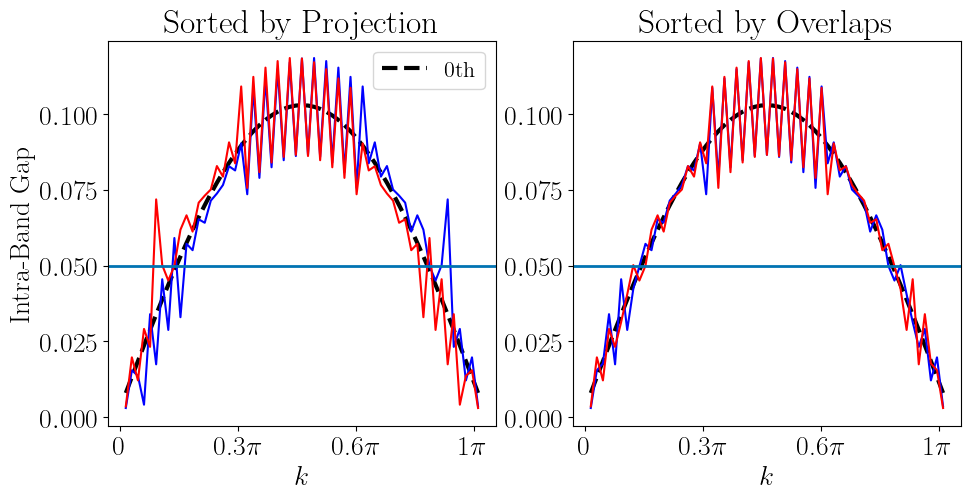

In [21]:
fig, ax = plt.subplots(1,2, figsize=(11,5))
ax[0].plot(k_single_band[:-1], np.diff(ep0) , c="black",linewidth=3, linestyle="dashed",label="0th")
ax[0].plot(k_single_band[:-1], np.diff(energies_p) , c="blue")
ax[0].plot(k_single_band[:-1], np.diff(energies_m) , c="red")


ax[1].plot(k_single_band[:-1], np.diff(ep0) , c="black",linewidth=3, linestyle="dashed",)
ax[1].plot(k_single_band[:-1], np.diff(over_energies_p) , c="blue")
ax[1].plot(k_single_band[:-1], np.diff(over_energies_m) , c="red")


ax[0].set_xlabel(r"$k$")
ax[0].set_ylabel(r"Intra-Band Gap")
ax[0].set_title(r"Sorted by Projection")
ax[1].set_xlabel(r"$k$")
ax[1].set_title(r"Sorted by Overlaps")
ax[0].legend()

ax[0].axhline(t, linewidth=2)
ax[1].axhline(t, linewidth=2)


# write x axis in units of pi
ax[0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

ax[1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))


## First Order

here, both bands have the same correction. Notice how the perturbation is zero at some momenta namely **the perturbation is very small around $\pi/2$** and larger at the edges of the brillouin zone.

In [22]:
kp = np.arccos(t/J[0] + np.cos(k_single_band))
 
E1_degenpp = 0.5/(L_qpc+1)*( xhi(k_single_band,k_single_band,bond_index) + xhi(kp,kp,bond_index) 
                           + np.sqrt((xhi(k_single_band,k_single_band,bond_index) - xhi(kp,kp,bond_index))**2 + 
                                     4*xhi(k_single_band,kp,bond_index)**2 ) ) 

E1_degenpm = 0.5/(L_qpc+1)*( xhi(k_single_band,k_single_band,bond_index) + xhi(kp,kp,bond_index) 
                           - np.sqrt((xhi(k_single_band,k_single_band,bond_index) - xhi(kp,kp,bond_index))**2 + 
                                     4*xhi(k_single_band,kp,bond_index)**2 ) ) 

# the nans are where the momenta go out of the band so they do not affect the degeneracies
ind_nan = np.where(np.isnan(E1_degenpp))[0]
E1_degenpp[ind_nan] = 1/(L_qpc+1)*(xhi(k_single_band[ind_nan],k_single_band[ind_nan],bond_index))
E1_degenpm[ind_nan] = 1/(L_qpc+1)*(xhi(k_single_band[ind_nan],k_single_band[ind_nan],bond_index))

/var/folders/2f/glb70vy54y71xvcj1yp0fsnh0000gn/T/ipykernel_62808/2265177395.py:1: RuntimeWarning: invalid value encountered in arccos
  kp = np.arccos(t/J[0] + np.cos(k_single_band))


Text(0, 0.5, '$E(k)^{(1)}$')

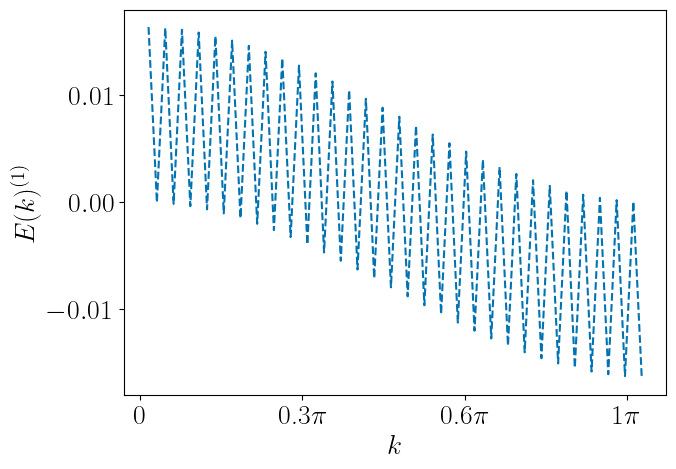

In [23]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

# First order corrections
e1 = (1/(L_qpc+1))*np.sin(bond_index*k_single_band)*np.sin(bond_index*k_single_band+k_single_band)

plt.plot(k_single_band, e1,linestyle="dashed")
#plt.plot(k_single_band,E1_degenpp, label="Degen")
#plt.plot(k_single_band,E1_degenpm, label="Degen")


ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,
                                                             pos: r'{:.0g}$\pi$'.format(val/np.pi)
                                                             if val !=0 else '0'))

#plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$E(k)^{(1)}$")

# plt.savefig(fig_route+"E1_corr={}_Omega={}_t={}.pdf".format(L_qpc, Omega,t),bbox_inches='tight')


## Second Order

Due to the normalization factor these corrections are super small nad the longer the chain the smaller they become

In [24]:
def get_second_order(krange, eta, Bond):
    # eta is +-t depemndeing on the qubit states
    E2 = []

    for k in krange:
        # remove k so the sums don't blow up
        p_range = np.asarray([x for x in krange if x != k])
        A_N = 1/(L_qpc+1)**2
    
        T1 = A_N*np.sum( (xhi(k, p_range, Bond)**2)/(-2*J[0]*(np.cos(k)-np.cos(p_range))) )
        T2 = A_N*(1/(2*eta))*xhi(k,k,bond_index)**2
        T3 = A_N*np.sum( (xhi(k, p_range, Bond)**2)/(-2*J[0]*(np.cos(k)-np.cos(p_range))+2*eta) )
    
        E2.append(T1 + T2 + T3) 
        
    E2 = np.asarray(E2)
    
    return E2
    

In [25]:
e2p_correction = get_second_order(k_single_band, t, bond_index)
e2m_correction = get_second_order(k_single_band, -t, bond_index)


# Testing where the degeneracies appear

There is a competition between two terms when we look at the perturbative corredctions between the states: the typical one from tight-binding model that is degenerate at the edges of the band, and a new one that mixes up the bands and seems to be dominating around the pi/2. _I think this second term is the one that is making both bands hiridize towards the middle_.

**If we taylor expand the denominator of the perturbative corrections around some point in k, we will see thatm, the condition for the perturbative series being well behaved is that $t<\Delta k$. Since $\Delta k$ is not constant, then the degeneracies will appear at different point of the band, depending on where we place $t$. This is the reason why the hibridization term wins sometimes** 

In [26]:
accos_bounds = [np.arccos(-1 + t) , np.arccos(1 - t)]
print(accos_bounds)

# for the upper band
# k_acos = k_single_band[(k_single_band<=accos_bounds[0]) & (k_single_band>=accos_bounds[1])] 

k_acos = k_single_band[k_single_band<=accos_bounds[0]] 
    
kupper = k_acos
E_upper = -2*J[0]*np.cos(kupper) + t

# momenta where the lower band is degenerate ~
k_acos = k_single_band[k_single_band>=accos_bounds[1]] 
klower = k_acos
E_lower = -2*J[0]*np.cos(klower) - t

# for the well behaved region
DeltaEk = np.diff(-2*J[0]*np.cos(k_single_band)) 

nondegen_indices = np.asarray([ind[0] for ind in np.argwhere(DeltaEk>2*t)])
if nondegen_indices.size == 0:
    nondegen_indices = [0,0]


[2.824032224298272, 0.3175604292915215]


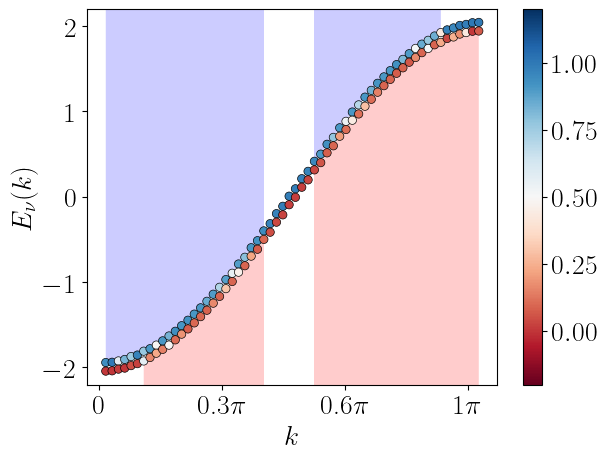

In [27]:
fig, ax = plt.subplots(1,1, figsize=(6.5,5))
# overlaps
sns.scatterplot(x=k_single_band, y=over_energies_p, hue= over_colors_p, hue_norm= c_norm, palette=cmap ,
                edgecolor="black",legend=None, ax=ax)

img = sns.scatterplot(x=k_single_band, y=over_energies_m, hue= over_colors_m, palette=cmap ,hue_norm= c_norm,
                edgecolor="black", legend=None,ax=ax)


plt.fill_between(kupper,E_upper, 2.5, color="blue", edgecolor=None,alpha=0.2 ,zorder=0)
plt.fill_between(klower,E_lower, -2.5, color="red", edgecolor=None,alpha=0.2 ,zorder=0)

ax.axvspan(k_single_band[nondegen_indices[0]], k_single_band[nondegen_indices[-1]], facecolor='white',zorder=0)


# Get the scatter object and attach colorbar
norm = plt.Normalize(c_norm[0], c_norm[1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable with no mappable object
plt.colorbar(sm, ax=ax)

ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$E_{\nu}(k)$")
ax.set_ylim(-2.2,2.2)

# write x axis in units of pi
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))
plt.tight_layout()
# plt.savefig(fig_route+"exact_energies_Lqpc={}_Omega={}_t={}.pdf".format(L_qpc, Omega,t),bbox_inches='tight')


# Entanglement

Since the eigenstates are properl sorted into bands, we see how much entanglement each of the k-eigenstates contributes by doing a schmidt decomposition. This is super easy because our eigenstates are pretty much in MPS form already 

In [63]:
def get_DD_init_for_fixed_k(k_prime):
    # calculated the initial conditions of the DD such that, when the QPC hits the bond
    # its state is the same as that of a DD initialized localized in the first site when 
    # the QPC for that case hits the bond with an average momentum k0=pi/2
    # k_prime: float. The momentum of the qpc particle
     
    alpha0 = np.cos( (t*bond_index)/(2*J[0])*(1/np.sin(k_prime) - 1) )
    beta0 = - 1j*np.sin( (t*bond_index)/(2*J[0])*(1/np.sin(k_prime) - 1) )
                        
    return alpha0, beta0

def schmidt_qubit_qpc(c_eigs):
    # calculates the schmidt decomposition between the QPC and qubit for some stae
    # given how we build our hamiltonian, the 0qubit-eigenstates are in the even indices
    # while the 1qubit ones are in the odd indices
    # c_eigs is the state vector

    # arange in MPS form for SVD
    col_1 = np.asarray(c_eigs[0::2]).reshape(-1,1)
    col_2 =  np.asarray(c_eigs[1::2]).reshape(-1,1)
    psi_mat = np.concatenate((col_1, col_2), axis=1)
    U, S, Vh = np.linalg.svd(psi_mat)

    return U, S, Vh

def time_evolve(Psi0, Tau, states_m, Energies_m, states_p, Energies_p):
    # time evolve a state up psi0 to time Tau with eigenstates states_m for anti-band
    # and states_p for symmetric band
    psi_t = []

    # lattice basis
    for i in range(0, 2*L_qpc):
        aa = np.zeros(2*L_qpc)+ 0*1j
        # energy basis
        for k in range(0,len(k_single_band)):
            aa += np.exp(-1j*Tau*Energies_m[k])*np.conj(states_m[:,k])*states_m[i,k]+ \
                    np.exp(-1j*Tau*Energies_p[k])*np.conj(states_p[:,k])*states_p[i,k]

        psi_t.append(np.dot(Psi0,aa))

    return np.asarray(psi_t)


In [64]:
Svn_p = np.zeros(L_qpc)
Svn_m = np.zeros(L_qpc)

for kind in range(0, L_qpc):
    # choose some eigenstate in the symmetric band
    U, S, Vh = schmidt_qubit_qpc(over_states_p[:,kind])
    schmis = S**2
    # calculate the entropy
    Svn_p[kind] = -1*np.sum(schmis*np.log(schmis))
    # choose some eigenstate in the anti-symetric band
    U, S, Vh = schmidt_qubit_qpc(over_states_m[:,kind])
    schmis = S**2
    # calculate the entropy
    Svn_m[kind] = -1*np.sum(schmis*np.log(schmis))


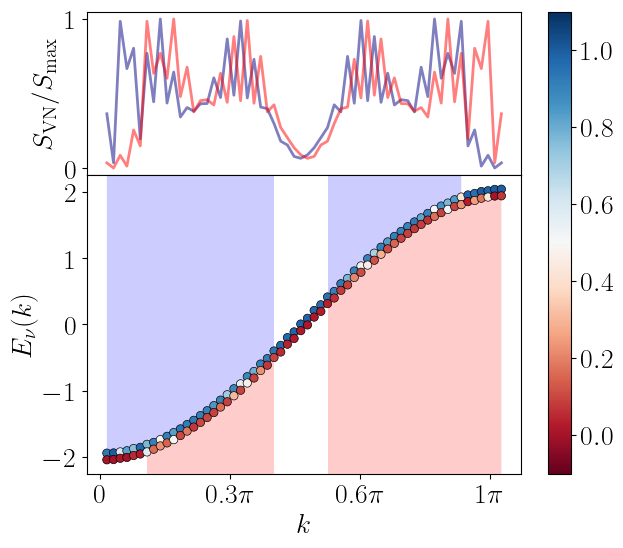

In [65]:
c_norm = (-0.1,1.1)

fig, ax = plt.subplots(2,1,figsize=(7,6), sharex=True ,gridspec_kw={'height_ratios': [0.55, 1]})

# entropy
ax[0].plot(k_single_band, Svn_p/np.log(2), c = "navy", linewidth=2, alpha = 0.5)
ax[0].plot(k_single_band, Svn_m/np.log(2), c = "red", linewidth=2,alpha = 0.5)

# bands
sns.scatterplot(x=k_single_band, y=over_energies_p, hue= over_colors_p, hue_norm= c_norm, palette=cmap ,
                edgecolor="black",legend=None, ax=ax[1], alpha=1.0)

img = sns.scatterplot(x=k_single_band, y=over_energies_m, hue= over_colors_m, palette=cmap ,hue_norm= c_norm,
                edgecolor="black", legend=None,ax=ax[1],alpha=1.0)


ax[1].fill_between(kupper,E_upper, 2.5, color="blue", edgecolor=None,alpha=0.2 ,zorder=0)
ax[1].fill_between(klower,E_lower, -2.5, color="red", edgecolor=None,alpha=0.2 ,zorder=0)

ax[1].axvspan(k_single_band[nondegen_indices[0]], k_single_band[nondegen_indices[-1]], facecolor='white',zorder=0)


# Get the scatter object and attach colorbar
norm = plt.Normalize(c_norm[0], c_norm[1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable with no mappable object

plt.subplots_adjust(hspace=0.0)  # reduce spacing
plt.colorbar(sm, ax=ax)

ax[0].set_ylabel(r"$S_{\rm{VN}}/S_{\rm{max}}$")
ax[1].set_xlabel(r"$k$")
ax[1].set_ylabel(r"$E_{\nu}(k)$")
ax[1].set_ylim(-2.2 - t,2.2 + t)

# write x axis in units of pi
ax[1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

plt.savefig(fig_route+"exact_energies_Lqpc={}_Omega={}_t={}.pdf".format(L_qpc, Omega,t),bbox_inches='tight')


Now  If we do the **schmidt decomposition** for a state that is a super position of states, we will get the total entropy of a given systems. The initial conditions are the initial coefficients (probabilities) of the superposition. Here we consider a gaussian wavepacket+qubit

In [36]:
Delta = 2.0
centered_at = 0 # initial position
max_Tau = 100

print(L_qpc/(2 * J[0] * np.sin(np.pi/2)))
print(bond_index/(2 * J[0] * np.sin(0.14*np.pi)))

30.0
35.22951984081527


In [32]:
# for the qutip comparison
data_df = pd.read_csv('../data/exp_pro/exploration_data_L=21.csv')
data_df.rename(columns={"band_width": "x_spread"}, inplace=True)
data_df = data_df.drop(["Unnamed: 0"], axis=1).drop_duplicates()

cond = (data_df["t"] == t) & (data_df["x_spread"] == Delta) & (data_df["Omega"] == Omega)
curr_df = data_df[cond].copy()

curr_df.head()

,L_qpc,max_time,tsteps,bond_index,x_spread,k0,J_prime,t,Omega,vg,...,min_purity,max_VN_entropy,entanglement_timeskip,T_mean,ddot0,kick,theta_f,phi_f,delta_phi,dd_density_hit
189,21,18.0,400,7,2.0,1.178097,1.0,0.05,0.4,1.847759,...,0.970038,0.078769,10,0.842339,fixed,0.478199,1.013016,1.270563,0.300234,0.969969
317,21,18.0,400,7,2.0,0.981748,1.0,0.05,0.4,1.662939,...,0.966126,0.087070,10,0.845435,fixed,0.510674,1.099418,1.259784,0.311013,0.970351
396,21,18.0,400,7,2.0,1.099557,1.0,0.05,0.4,1.782013,...,0.968413,0.082244,10,0.842932,fixed,0.489333,1.041772,1.265189,0.305608,0.970084
426,21,18.0,400,7,2.0,1.413717,1.0,0.05,0.4,1.975377,...,0.972918,0.072509,10,0.843260,fixed,0.457490,0.995341,1.288353,0.282443,0.969583
561,21,18.0,400,7,2.0,0.392699,1.0,0.05,0.4,0.765367,...,0.971170,0.076326,10,0.876101,fixed,0.691477,1.142544,1.291406,0.279390,0.966330


In [33]:
K0_list = np.linspace(curr_df["k0"].min(), 0.5*np.pi) # np.sort(curr_df["k0"].unique()) # np.linspace(curr_df["k0"].min(), 0.5*np.pi)

x = np.arange(0,L_qpc) 

entropies = []
for K0 in K0_list:
    # calculate the spread of the wave packet based on the time it takes the particle to hit the bond
    alphas = np.exp(-0.5*(x - centered_at)**2/(Delta**2)) * np.exp(1j * K0 *(x-centered_at))
    norm_ = np.linalg.norm(alphas)
    alphas = alphas/norm_
    
    # this is so we get the same qubit state when the qpc hits the bond
    beta0, beta1 = get_DD_init_for_fixed_k(K0)

    psi_0 = np.kron(alphas, [beta1, beta0])
    
    # the tau is given by k0 to avoid reflections
    Tau = L_qpc/(2 * J[0] * np.sin(K0))
    if Tau > max_Tau:
        Tau = max_Tau
    psi_t = time_evolve(psi_0, Tau, over_states_m, over_energies_m, over_states_p, over_energies_p)
    U, S, Vh = schmidt_qubit_qpc(psi_t)
    schmis = S**2
    entropies.append(-1*np.sum(schmis*np.log(schmis+1e-17))) # avoid log(0)

entropies = np.asarray(entropies)

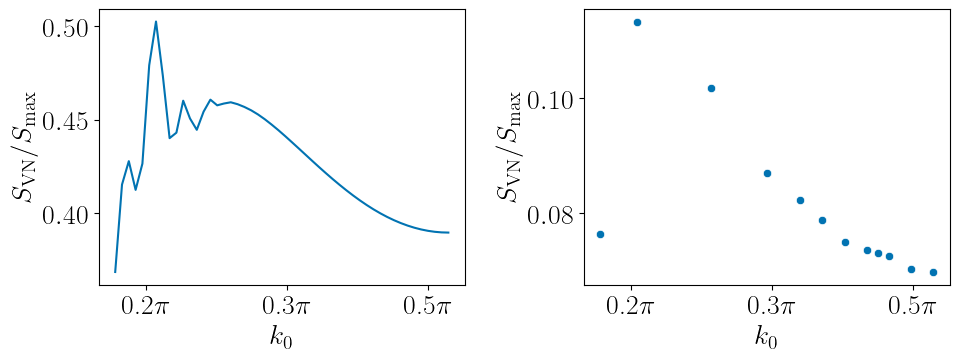

In [34]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(K0_list, entropies/np.log(2))
# divide by the maximum entanglement log(2)
curr_df["Svn_norm"] = curr_df["max_VN_entropy"]/np.log(2)
sns.scatterplot(data=curr_df,x="k0",y="max_VN_entropy", ax=ax[1])

ax[0].set_ylabel(r"$S_{\rm{VN}}/S_{\rm{max}}$")

ax[0].set_xlabel(r"$k_0$")

ax[1].set_ylabel(r"$S_{\rm{VN}}/S_{\rm{max}}$")
ax[1].set_xlabel(r"$k_0$")

# write x axis in units of pi
ax[0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

ax[1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))
plt.tight_layout()

plt.savefig(fig_route+"wavepacket_entropies_Lqpc={}_Omega={}_t={}.pdf".format(L_qpc, Omega,t),bbox_inches='tight')


# Time Evolution And Schmidt Decomposition

Also for comparisson with scattering

In [35]:

    
def get_QPC_occupations(Psi):
    # apply the density opperator to the full composite Psi and return the
    # densities a teach of the QPC sites
    occ_list = []

    for j in range(0,L_qpc):
        basis_j = np.zeros(L_qpc)
        basis_j[j] = 1
        # create density operator for the jth qoc lattice
        ketbra = np.outer(basis_j, np.conj(basis_j))
        # tensor with the qubit identity
        Nj_op = np.kron(ketbra, np.eye(2))
        occ_list.append(np.vdot(Psi, Nj_op @ Psi).real)
    return np.asarray(occ_list)

def get_qubit_occupations(Psi):
    # apply the density opperator to the full composite Psi and return the
    # densities a teach of the QPC sites
    occ_list = []

    # create density operator for the 0th qubit state 
    ketbra = np.outer([1,0], np.conj([1,0]))
    # tensor with the qubit identity
    Nj_op = np.kron(np.eye(L_qpc), ketbra)
    return np.vdot(Psi, Nj_op @ Psi).real

def get_first_order_state(k,e_nu, state_nu, state_mu):
    # calculate first order corrections to the eigenstate label by k (QPC), nu (qubit)
    # k_basis is the QPC basis and state_nu, state_mu are the qubit ones
    # which change dependeing on the bands we are calcualting in

    indices = np.where(k_single_band != k)[0]
    phi1_km = np.zeros(2*L_qpc) + 0j
    # sum over p \neq k
    for i in indices:
        p = k_single_band[i]
        T1 = np.kron(k_basis[:,i],state_nu)*xhi(k,p, bond_index)/(-2*J[0]*(np.cos(k)-np.cos(p)))    # band mixing term
        T2 = np.kron(k_basis[:,i],state_mu)*xhi(k,p, bond_index)/(2*e_nu-2*J[0]*(np.cos(k)-np.cos(p)))
        
        phi1_km += T1 + T2
    
    phi1_km += np.kron(k_basis[:,i],state_mu)*xhi(k,k, bond_index)/(2*e_nu)
    
    return (1/(L_qpc+1))*phi1_km

def get_transmision_proba(Om, k0,dot_density, Delta, k_arr ,J, Bond):
    # in the limit where we have very localized state the transmision probability is approximately that of the
    # one for K0
    V0 =  Om*J*dot_density
    T0 = 1 / (1 + (V0 / k_arr) ** 2)

    # effective mass
    m = 2*J*np.cos(k0)

    # the momentum distribution
    k_arr = np.linspace(-200, 200, 5000)
    Psi0k_abs = np.exp(-(Delta** 2)*(k_arr - k0) ** 2)
    # now with the wave packet weights
    T_k = 1 / (1 + (V0*m/ k_arr) ** 2)
    T_tot = simpson(T_k * Psi0k_abs, dx=k_arr[1] - k_arr[0])

    return T0, T_tot


In [36]:
K0 = np.pi/2
alphas = np.exp(-0.5*(x - centered_at)**2 / (Delta**2)) * np.exp(1j * K0 *(x-centered_at))
norm_ = np.linalg.norm(alphas)
alphas = alphas/norm_

time_range = np.linspace(0,L_qpc/(2 * J[0] * np.sin(K0)))

# this is so we get the same qubit state when the qpc hits the bond
beta0, beta1 = get_DD_init_for_fixed_k(K0)
psi_0 = np.kron(alphas, [beta1, beta0])
trajectories = np.zeros((L_qpc, len(time_range)))
qubit_traj = []
St = []

i = 0
for Tau in time_range:
    psi_t = time_evolve(psi_0, Tau,over_states_m, over_energies_m, over_states_p, over_energies_p)
    occupations = get_QPC_occupations(psi_t)
    qubit_traj.append(get_qubit_occupations(psi_t))
    
    U, S, Vh = schmidt_qubit_qpc(psi_t)
    schmis = S**2
    trajectories[:,i] = occupations
    St.append(-1*np.sum(schmis*np.log(schmis+1e-17))) # avoid log(0)

    i += 1

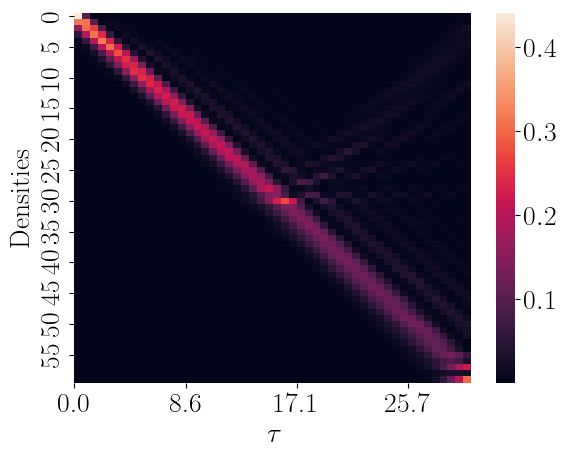

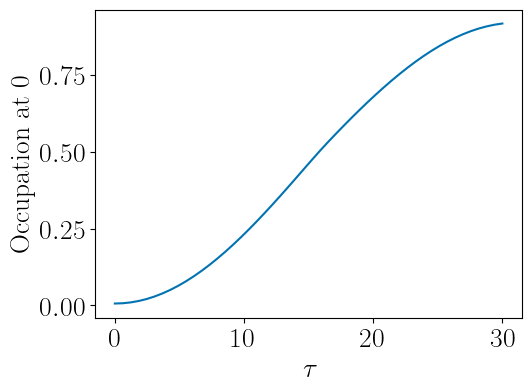

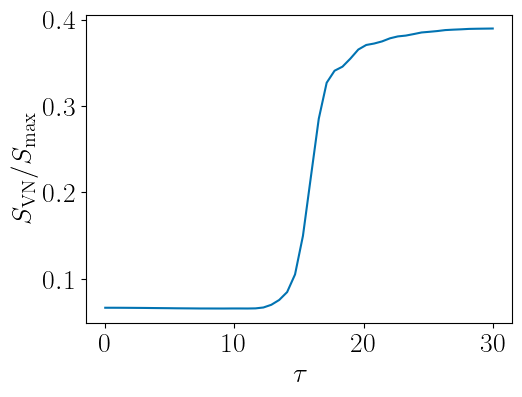

In [37]:

# plot the occupations as a heatmap with lattice site in the y axis and time on the x
ax = sns.heatmap(trajectories)
ax.set_xlabel(r"$\tau$")
ax.set_ylabel("Densities")
# time ticks
delta_tau = time_range[1] - time_range[0]
tick_posx = np.arange(0,len(time_range),14)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)
ax.set_xticks(tick_posx,xtick_label);
plt.savefig(fig_route+"trajectory_exact_Lqpc={}_Omega={}_t={}.pdf".format(L_qpc, Omega,t),bbox_inches='tight')

fig, ax = plt.subplots(1,1,figsize=(5.5,4))
plt.plot(time_range, qubit_traj)
plt.xlabel(r"$\tau$")
plt.ylabel(r"Occupation at 0")
fig, ax = plt.subplots(1,1,figsize=(5.5,4))
plt.plot(time_range,St/np.log(2))
ax.set_ylabel(r"$S_{\rm{VN}}/S_{\rm{max}}$")
ax.set_xlabel(r"$\tau$")
plt.savefig(fig_route+"entropy_time_exact_Lqpc={}_Omega={}_t={}.pdf".format(L_qpc, Omega,t),bbox_inches='tight')



Now with the approx. perturbative eigenstates

In [38]:
phi = np.pi/2
n_ = range(1,L_qpc+1)
k_basis = np.zeros((L_qpc, L_qpc))
# qubit basis
qu_0 = np.asarray([1,0])
qu_1 = np.asarray([0,1])

qu_m = np.sqrt(1/2)*(qu_0-np.exp(1j*phi)*qu_1)
qu_p = np.sqrt(1/2)*(qu_0+np.exp(1j*phi)*qu_1)

# get the zeroth order eigenvectors
for i in range(0,L_qpc):
    k = k_single_band[i]
    k_basis[:,i] = np.sqrt(2/(L_qpc+1))*np.sin(n_*k)

# get the erturbative energies
Em_approx = -2*J[0]*np.cos(k_single_band) - t + Omega*e1 + (Omega**2)*e2m_correction
Ep_approx = -2*J[0]*np.cos(k_single_band) + t + Omega*e1 + (Omega**2)*e2p_correction


In [39]:
# now create the corrected eigenvectors for eahc band
psi_m_approx = np.zeros((2*L_qpc, L_qpc)) + 0j
psi_p_approx = np.zeros((2*L_qpc, L_qpc)) + 0j

for eig_in in range(0,len(k_single_band)):
    k = k_single_band[eig_in]

    # calcualte and normalize the eigenstates
    psi_m_approx[:,eig_in] = np.kron(k_basis[:,eig_in],qu_m)  + Omega*get_first_order_state(k,-t, qu_m, qu_p)
    psi_m_approx[:,eig_in] = psi_m_approx[:,eig_in]/np.linalg.norm(psi_m_approx[:,eig_in])
    psi_p_approx[:,eig_in] = np.kron(k_basis[:,eig_in],qu_p)  + Omega*get_first_order_state(k,-t, qu_p, qu_m)
    psi_p_approx[:,eig_in] = psi_p_approx[:,eig_in]/np.linalg.norm(psi_p_approx[:,eig_in])
 
np.linalg.norm(psi_p_approx[:,eig_in])

1.0

In [40]:

psi_0 = np.kron(alphas, [beta0, beta1])
trajectories_approx = np.zeros((L_qpc, len(time_range)))
St = []

i = 0
for Tau in time_range:
    psi_t = time_evolve(psi_0, Tau, psi_m_approx, Em_approx, psi_p_approx, Ep_approx)
    occupations = get_QPC_occupations(psi_t)
    
    U, S, Vh = schmidt_qubit_qpc(psi_t)
    schmis = S**2
    trajectories_approx[:,i] = occupations
    St.append(-1*np.sum(schmis*np.log(schmis+1e-17))) # avoid log(0)

    i += 1
    

Text(0.5, 0, '$\\tau$')

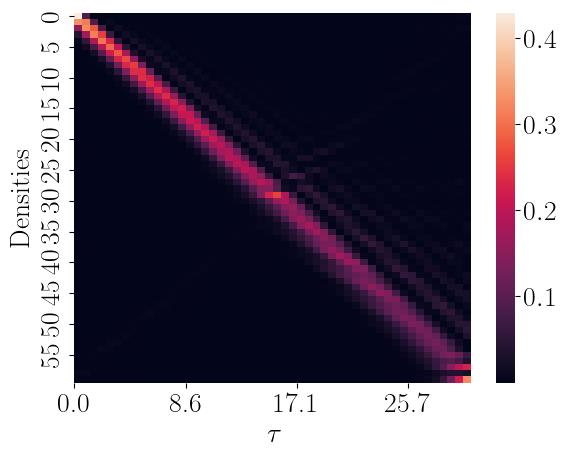

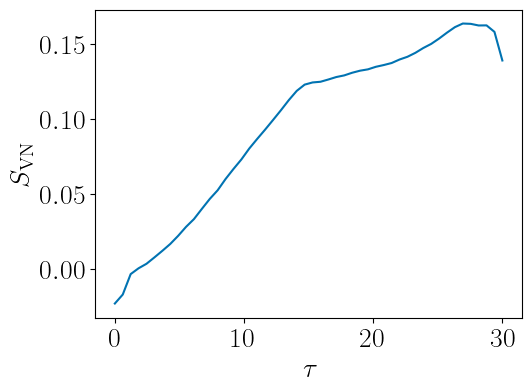

In [41]:
# plot the occupations as a heatmap with lattice site in the y axis and time on the x
ax = sns.heatmap(trajectories_approx)
ax.set_xlabel(r"$\tau$")
ax.set_ylabel("Densities")

# time ticks
delta_tau = time_range[1] - time_range[0]
tick_posx = np.arange(0,len(time_range),14)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)
ax.set_xticks(tick_posx,xtick_label);
# plt.savefig(fig_route+"trajectory_perturb_Lqpc={}_Omega={}_t={}.pdf".format(L_qpc, Omega,t),bbox_inches='tight')


fig, ax = plt.subplots(1,1,figsize=(5.5,4))

plt.plot(time_range,St)
ax.set_ylabel(r"$S_{\rm{VN}}$")
ax.set_xlabel(r"$\tau$")

Also Caluclate the transmision coefficient for comparison

In [42]:

n_bond = trajectories[bond_index,:] + trajectories[bond_index+1,:]
n_left = np.sum(trajectories[:bond_index,:] , axis=0)
n_right = np.sum(trajectories[bond_index+2:,:] , axis=0)

# the dot density is always around 0.4
_, T_coef = get_transmision_proba(Omega, K0, 0.4 , Delta, k_single_band ,J[0], bond_index)


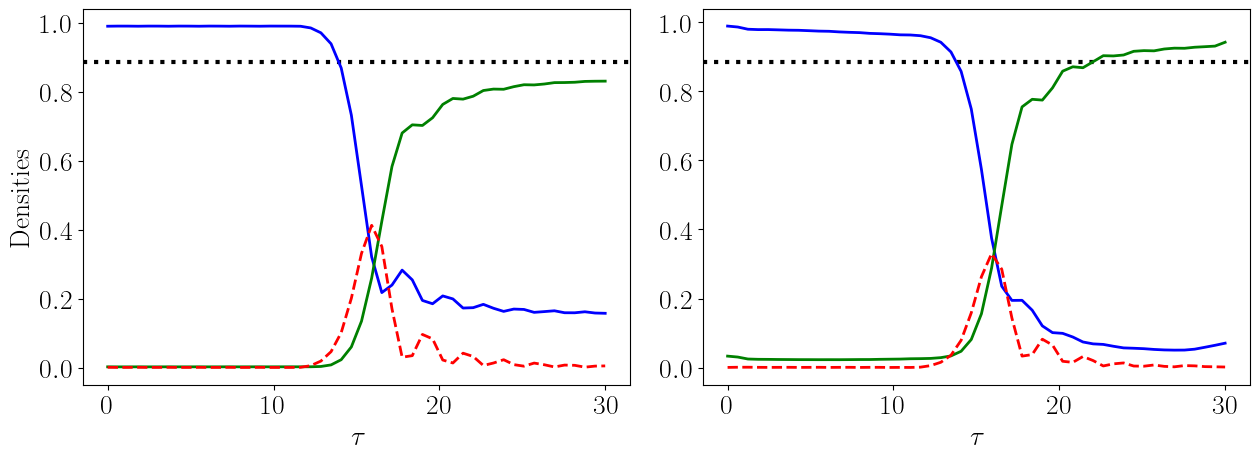

In [43]:
fig, ax = plt.subplots(1,2,figsize=(13,5))


n_bond_approx = trajectories_approx[bond_index,:] + trajectories_approx[bond_index+1,:]
n_left_approx = np.sum(trajectories_approx[:bond_index,:] , axis=0)
n_right_approx = np.sum(trajectories_approx[bond_index+2:,:] , axis=0)

ax[0].axhline(T_coef, linewidth=3, c="black", linestyle="dotted")
ax[0].plot(time_range,n_left, c='blue', linewidth=2)
ax[0].plot(time_range,n_right, c='green', linewidth=2)
# ax[0].plot(time_range,n_bond+ n_left+n_right, c="black")
ax[0].plot(time_range,n_bond,label="Bond", linestyle="dashed", c='red',linewidth=2)

ax[1].axhline(T_coef, linewidth=3, c="black", linestyle="dotted")
ax[1].plot(time_range,n_left_approx, c='blue', linewidth=2)
ax[1].plot(time_range,n_right_approx, c='green', linewidth=2)
ax[1].plot(time_range,n_bond_approx, linestyle="dashed", c='red',linewidth=2)

ax[0].set_xlabel(r"$\tau$")
ax[1].set_xlabel(r"$\tau$")

ax[0].set_ylabel("Densities")

plt.tight_layout()

plt.savefig(fig_route+"occupations_Lqpc={}_Omega={}_t={}.pdf".format(L_qpc, Omega,t),bbox_inches='tight')


# $K_0$ vs $t$ phase diagram

We will use exact diagonalization like we did just now to generate more datapoints

In [44]:
werrrrrrrr

NameError: name 'werrrrrrrr' is not defined

In [ ]:
L_qpc = 60
L = L_qpc + 2
Omega = 0.4
J_prime = 1
bond_index = int(L_qpc/2)
J = np.ones(L_qpc) # QPC hopping
J[bond_index] = J_prime  
Delta = 2.0
centered_at = 0 # initial position
max_Tau = 100

t_list = [0.01, 0.02 ,0.03, 0.04,0.05, 0.06 ,0.07, 0.06 ,0.09, 0.1, 0.15 ,0.2, 0.25 ,0.3, 0.35 ,0.4, 0.45 ,0.5, 0.6 ,0.8, 1.0]

pp = 22
k0_list = np.linspace(0.12*np.pi, 0.5*np.pi, pp )
print(len(t_list))

print(len(t_list) * len(k0_list))
k0_list

In [ ]:
Id_qpc = np.eye(L_qpc)
plusket = np.asarray([1/np.sqrt(2),1/np.sqrt(2)])
p_ketbra = np.outer(plusket,plusket)
Psym = np.eye(2*L_qpc) - np.kron(Id_qpc, p_ketbra) # tensor product

k_single_band = np.arange(1,L_qpc+1)*np.pi/(L_qpc+1)

x = np.arange(0,L_qpc) 

print(np.pi/(L_qpc+1))

data_dict = {"k0": [], "t":[], "Svn":[] }
len(psi_0)

In [ ]:
for t in t_list:
    print("doing t =", t)
    for K0 in k0_list:
        H_matrix, Hdeco = create_hamiltonians(L_qpc, t, bond_index)

        # Calculate the energies and eigenvectors
        energies, eigen_vecs = np.linalg.eig(H_matrix)
        # normalize
        eigen_vecs = eigen_vecs/ np.linalg.norm(eigen_vecs, axis=0)
        free_energies, free_eigen_vecs = np.linalg.eig(Hdeco)
        # normalize
        free_eigen_vecs = free_eigen_vecs/ np.linalg.norm(free_eigen_vecs, axis=0)

        # sort into bands by overlaps with free eigenstates        
        # calculate the overlaps between the eigenvectors of H0 and
        sorted_indices, over_matrix = sort_by_overlap_matrix(energies, free_eigen_vecs,eigen_vecs)

        # now sort the freee case into bands according to projection
        mindices, pindices = sort_by_projection(free_energies,free_eigen_vecs, Psym)
        
        # minus band
        free_energies_m = free_energies[mindices]
        free_states_m = free_eigen_vecs[:,mindices]
        # sort by magnitude
        free_energies_m, free_states_m = mag_sort(free_energies_m, free_states_m)
        
        # plus band
        free_energies_p = free_energies[pindices]
        free_states_p = free_eigen_vecs[:,pindices]
        # sort by magnitude
        free_energies_p, free_states_p = mag_sort(free_energies_p, free_states_p)
    
        # now sort the coupled eigenvectors and values according to max overlaps so they match with the free case
        sorted_e = energies[sorted_indices]
        sorted_vecs = eigen_vecs[:,sorted_indices]
        
        # minus band
        over_energies_m = sorted_e[mindices]
        over_states_m = sorted_vecs[:,mindices]
        # sort by magnitude
        over_energies_m, over_states_m = mag_sort(over_energies_m, over_states_m)
        
        # plus band
        over_energies_p = sorted_e[pindices]
        over_states_p = sorted_vecs[:,pindices]
        
        # sort by magnitude
        over_energies_p, over_states_p = mag_sort(over_energies_p, over_states_p)

        # calculate the spread of the wave packet based on the time it takes the particle to hit the bond
        alphas = np.exp(-0.5*(x - centered_at)**2/(Delta**2)) * np.exp(1j * K0 *(x-centered_at))
        norm_ = np.linalg.norm(alphas)
        alphas = alphas/norm_
        
        # this is so we get the same qubit state when the qpc hits the bond
        beta0, beta1 = get_DD_init_for_fixed_k(K0)
    
        psi_0 = np.kron(alphas, [beta1, beta0])
        
        # the tau is given by k0 to avoid reflections
        Tau = L_qpc/(2 * J[0] * np.sin(K0))

        psi_t = time_evolve(psi_0, Tau, over_states_m, over_energies_m, over_states_p, over_energies_p)
        U, S, Vh = schmidt_qubit_qpc(psi_t)
        schmis = S**2
        entropy_ = -1*np.sum(schmis*np.log(schmis+1e-17))
        data_dict["Svn"].append(entropy_)
        data_dict["k0"].append(K0)
        data_dict["t"].append(t)

entropy_df = pd.DataFrame.from_dict(data_dict)

In [ ]:
len(over_energies_p), np.shape(H_matrix)

In [ ]:
S_df = entropy_df.pivot_table(index='k0', columns='t', values='Svn', 
                          aggfunc='mean')

fig, ax = plt.subplots(1,1,figsize=(bwidth,bwidth))


k_array = S_df.index
t_array = S_df.columns
im = ax.contourf(S_df.values,extent=[min(t_array), max(t_array),min(k_array), max(k_array)])
ax.set_ylabel(r"$k_0$")
ax.set_xlabel(r"$t$")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax, shrink=0.9)   
cbar.ax.set_ylabel(r'$S_{VN}$', rotation=90)
